# Convolutional Neural Network: fashtion mnist dataset

Chúng ta đã quá quen với việc sử dụng MNIST. MNIST là cơ sở dữ liệu về chữ số viết tay, được sử dụng rất rộng rãi trong cộng đồng AI/ML. MNIST thường được thử đầu triên khi có một thuật toán phân loại ảnh mới. Nhưng ngoài ra chúng ta còn có tập Fashion-MNIST được tạo ra gần đây có kích thước tương tự MNIST nhưng các ảnh là ảnh xám của trang phục các nhãn: (0) T-shirt/top, (1) Trouser, (2) Pullover, (3) Dress, (4) Coat, (5) Sandal, (6) Shirt, (7) Sneaker, (8) Bag, (9) Ankle boot. Fashion-MNIST cũng có 10 class, 60000 ảnh cho training, 10000 ảnh cho test, mỗi ảnh có kích thước 28x28 pixel và là các ảnh xảm chỉ một channel.

Sau đây ta sẽ thực hiện load dataset

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

trainLoader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testLoader = DataLoader(test_dataset, batch_size=64, shuffle=False)


#set label loại theo name
classes = ["T-shirt/top",
         "Trouser",
         "Pullover",
         "Dress",
         "Coat",
         "Sandal",
         "Shirt",
         "Sneaker",
         "Bag",
         "Ankle boot"]

100%|██████████| 26.4M/26.4M [00:03<00:00, 7.78MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 135kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.46MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.1MB/s]


Ta sẽ xem thử ảnh trong 1 mẫu

Sandal Pullover Sandal Bag  


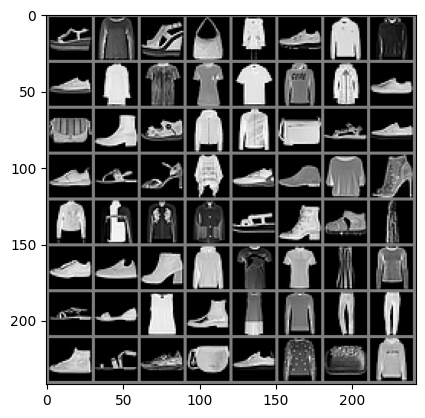

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision


def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

dataiter = iter(trainLoader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Sau khi ta nhìn nhận ta có thể dùng một số thử thuật để trực quan hóa và quan sát dữ liệu nhưng phần đó ta sẽ làm sao để có thể đẩy cao độ chính xác của ảnh.

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)    # 28x28 -> 24x24
        self.pool = nn.MaxPool2d(2, 2)     # 24x24 -> 12x12
        self.conv2 = nn.Conv2d(6, 16, 5)   # 24x24 -> 20x20 -> 16x16

        # Tính số chiều đầu vào cho fc1 tự động
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 28, 28)
            dummy = self.pool(self.conv2(self.pool(self.conv1(dummy))))
            self.flatten_dim = dummy.view(1, -1).size(1) + 1

        self.fc1 = nn.Linear(self.flatten_dim, 120)
        self.fc2 = nn.Linear(121, 84)
        self.fc3 = nn.Linear(85, 10)
    def add_ones_column(self,x):
      if x.dim() != 2:
        raise ValueError("Input tensor must be 2D.")
      ones_column = torch.ones(x.size(0), 1, device=x.device)
      return torch.cat((ones_column, x), dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.add_ones_column(x)
        x = F.relu(self.fc1(x))
        x = self.add_ones_column(x)
        x = F.relu(self.fc2(x))
        x = self.add_ones_column(x)
        return self.fc3(x)


In [5]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

@torch.no_grad()
def evaluate_model(dataloader, model):
  model.eval()
  total_correct = 0
  total_samples = 0
  all_preds = []
  all_labels = []
  for X, y in dataloader:
    X, y = X.to(DEVICE), y.to(DEVICE)
    preds = model(X)
    predicted = torch.argmax(preds,dim=1)
    total_correct += (predicted == y).sum().item()
    total_samples += y.size(0)
    all_preds.extend(predicted.cpu().numpy())
    all_labels.extend(y.cpu().numpy())
  acc = total_correct / total_samples
  f1 = f1_score(all_labels, all_preds, average='macro')
  return acc, f1

### 3. Định nghĩa loss function và otimizer

In [6]:
net = Net().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.003)

### 4. train the network

In [7]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0
    for X, y in dataloader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

for epoch in range(10):
    loss = train_loop(trainLoader, net, criterion, optimizer)
    acc, f1 = evaluate_model(testLoader, net)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f} , accuracy: {acc:.4f}, f1: {f1:.4f}")
print("Finished")

Epoch 1, Loss: 0.5530 , accuracy: 0.8401, f1: 0.8355
Epoch 2, Loss: 0.3653 , accuracy: 0.8712, f1: 0.8699
Epoch 3, Loss: 0.3224 , accuracy: 0.8787, f1: 0.8764
Epoch 4, Loss: 0.2975 , accuracy: 0.8760, f1: 0.8754
Epoch 5, Loss: 0.2834 , accuracy: 0.8869, f1: 0.8866
Epoch 6, Loss: 0.2700 , accuracy: 0.8816, f1: 0.8784
Epoch 7, Loss: 0.2558 , accuracy: 0.8915, f1: 0.8913
Epoch 8, Loss: 0.2490 , accuracy: 0.8867, f1: 0.8852
Epoch 9, Loss: 0.2367 , accuracy: 0.8888, f1: 0.8895
Epoch 10, Loss: 0.2304 , accuracy: 0.8935, f1: 0.8933
Finished


In [8]:
PATH = './fashion_net.pth'
torch.save(net.state_dict(), PATH)

### 5. kiểm tran trên tập test.

GroundTruth:  Ankle boot Pullover Trouser Trouser Shirt


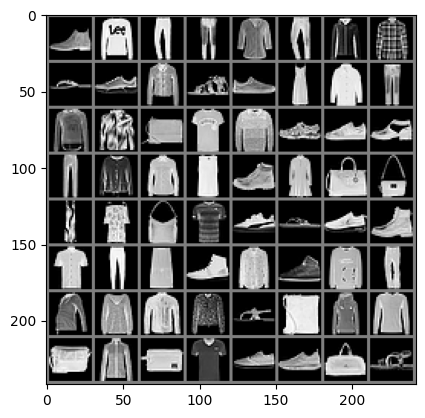

In [9]:
dataiter = iter(testLoader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(5)))

In [10]:
net = Net().to(DEVICE)
net.load_state_dict(torch.load('/content/fashion_net.pth'))
outputs = net(images.to(DEVICE))

Lấy ra nhãn dựa vào xác xuất lớn nhất của phân phối xác xuất đầu ra

In [11]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(5)))

Predicted:  Ankle boot Pullover Trouser Trouser Shirt


Có thể thấy được kết quả khá tốt và 5 cái đầu dự đoán gần như hoàn toàn đúng. kiểm tra trên toàn bộ các quan sát. kiễm tra mức độ chính xác trên từng class một.

In [13]:
 class_correct = list(0. for i in range(10))
 class_total = list(0. for i in range(10))
 with torch.no_grad():
     for data in testLoader:
         images, labels = data
         images, labels = images.to(DEVICE), labels.to(DEVICE)
         outputs = net(images)
         _, predicted = torch.max(outputs, 1)
         c = (predicted == labels).squeeze()
         for i in range(4):
             label = labels[i]
             class_correct[label] += c[i].item()
             class_total[label] += 1
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of T-shirt/top : 90 %
Accuracy of Trouser : 93 %
Accuracy of Pullover : 81 %
Accuracy of Dress : 87 %
Accuracy of  Coat : 81 %
Accuracy of Sandal : 96 %
Accuracy of Shirt : 61 %
Accuracy of Sneaker : 94 %
Accuracy of   Bag : 95 %
Accuracy of Ankle boot : 96 %


Có thể thấy chỉ với một cấu trúc đơn gian mà đã có thể đạt kết quả như vậy nếu có thể cải thiện thêm thì kết quả sẽ cao hơn nữa.